In [1]:
import os
import copy
import time
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.quantization as tq
import torchvision
import torchvision.transforms as transforms
from torchvision import models as torchvision_models
from torchvision.models.resnet import BasicBlock
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#  -----------------------------------------------------
# Settings
#  -----------------------------------------------------

if torch.backends.mps.is_available():
    device_train = torch.device('mps')
    print(f"Using MPS for FP32 training.")
else:
    device_train = torch.device('cpu')
    print(f"Using CPU for training.")

# CPU for quantization operations.
device_quant = torch.device('cpu')
print(f"Using CPU for quantization operations.")

# Quantization backend to qnnpack.
torch.backends.quantized.engine = 'qnnpack'
print(f"Using qnnpack backend.")

BATCH_SIZE = 128
EPOCHS_BASELINE = 10  
EPOCHS_QAT = 3       
EPOCHS_KD = 3
PRINT_FREQ = 100

os.makedirs('./quantization_results', exist_ok=True)

Using MPS for FP32 training.
Using CPU for quantization operations.
Using qnnpack backend.


In [ ]:
#  -----------------------------------------------------
# Data: CIFAR-10
#  -----------------------------------------------------

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

Training samples: 50000
Test samples: 10000


In [ ]:
#  -----------------------------------------------------
# Model
#  -----------------------------------------------------

# ResNet18 configured for CIFAR-10.
def get_resnet18(num_classes=10, pretrained=False):
    model = torchvision_models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    prepare_residual_blocks_for_quant(model)
    return model


# Quantization stubs.
class QuantStubWrapper(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module
        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.module(x)
        x = self.dequant(x)
        return x


# Making sure the model exposes Quant/DeQuant stubs exactly once.
def wrap_with_quant_stubs(model: nn.Module) -> nn.Module:
    if isinstance(model, QuantStubWrapper):
        return model
    return QuantStubWrapper(model)


def _basicblock_forward_quant(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out = self.skip_add.add(out, identity)
    out = self.relu(out)

    return out


# Prepare residual blocks for quantization.
def prepare_residual_blocks_for_quant(model: nn.Module) -> nn.Module:
    for module in model.modules():
        if isinstance(module, BasicBlock) and not hasattr(module, 'skip_add'):
            module.skip_add = nn.quantized.FloatFunctional()
            module.forward = types.MethodType(_basicblock_forward_quant, module)
    return model


# Fuse Conv+BN+ReLU modules in ResNet18 for better quantization.
def fuse_resnet18_modules(model):
    fused_count = 0
    target_model = getattr(model, 'module', model)
    for module_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        if hasattr(target_model, module_name):
            layer = getattr(target_model, module_name)
            for block in layer:
                if hasattr(block, 'conv1') and hasattr(block, 'bn1'):
                    try:
                        if hasattr(block, 'relu'):
                            tq.fuse_modules(block, ['conv1', 'bn1', 'relu'], inplace=True)
                        else:
                            tq.fuse_modules(block, ['conv1', 'bn1'], inplace=True)
                        fused_count += 1
                    except Exception:
                        pass
                
                if hasattr(block, 'conv2') and hasattr(block, 'bn2'):
                    try:
                        tq.fuse_modules(block, ['conv2', 'bn2'], inplace=True)
                        fused_count += 1
                    except Exception:
                        pass
    return fused_count

In [ ]:
#  -----------------------------------------------------
# Utility functions
#  -----------------------------------------------------

# Evaluating the model on the specified device.
def evaluate_on_device(model, dataloader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    return 100.0 * correct / total


# Evaluating the model on CPU.
def evaluate_cpu(model, dataloader):
    return evaluate_on_device(model, dataloader, torch.device('cpu'))


# Measuring the latency of the model.
def measure_latency(model, device_type='cpu', num_runs=200, input_size=(1, 3, 32, 32)):
    device_local = torch.device(device_type)
    model = model.to(device_local)
    model.eval()
    
    dummy_input = torch.randn(input_size).to(device_local)
    
    # warmup.
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # measure.
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = time.time()
            _ = model(dummy_input)
            
            if device_type == 'mps':
                torch.mps.synchronize()
            
            times.append((time.time() - start) * 1000)
    
    return sum(times) / len(times)


def get_model_size_mb(filepath):
    return os.path.getsize(filepath) / (1024 * 1024)

In [9]:
#  -----------------------------------------------------
# 1) Baseline: Train ResNet-18 (FP32)
#  -----------------------------------------------------

print("1) Baseline: Train ResNet-18 (FP32)")

baseline = get_resnet18().to(device_train)
print(f"Parameters: {sum(p.numel() for p in baseline.parameters())/1e6:.2f}M")
print(f"Training on: {device_train}")

optimizer = optim.SGD(baseline.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8], gamma=0.1)
criterion = nn.CrossEntropyLoss()

print(f"\nTraining for {EPOCHS_BASELINE} epochs.")

for epoch in range(EPOCHS_BASELINE):
    baseline.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device_train), labels.to(device_train)
        
        optimizer.zero_grad()
        outputs = baseline(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % PRINT_FREQ == 0:
            print(f'  Epoch {epoch+1}/{EPOCHS_BASELINE}, Step {i+1}, '
                  f'Loss: {running_loss/PRINT_FREQ:.4f}, '
                  f'Train Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    scheduler.step()
    acc = evaluate_on_device(baseline, testloader, device_train)
    print(f'Epoch {epoch+1} complete. Test Accuracy: {acc:.2f}%')

acc_fp32 = evaluate_on_device(baseline, testloader, device_train)
lat_fp32 = measure_latency(baseline, 'mps' if device_train.type == 'mps' else 'cpu')

torch.save(baseline.state_dict(), './quantization_results/resnet18_fp32.pth')
size_fp32 = get_model_size_mb('./quantization_results/resnet18_fp32.pth')

print(f"{'-'*70}")
print(f"FP32 Baseline | Acc: {acc_fp32:.2f}%, Latency: {lat_fp32:.2f} ms, Size: {size_fp32:.2f} MB")
print(f"{'-'*70}")


1) Baseline: Train ResNet-18 (FP32)
Parameters: 11.17M
Training on: mps

Training for 10 epochs.
  Epoch 1/10, Step 100, Loss: 2.7684, Train Acc: 14.68%
  Epoch 1/10, Step 200, Loss: 2.0101, Train Acc: 19.29%
  Epoch 1/10, Step 300, Loss: 1.8086, Train Acc: 23.41%
Epoch 1 complete. Test Accuracy: 37.48%
  Epoch 2/10, Step 100, Loss: 1.5786, Train Acc: 41.49%
  Epoch 2/10, Step 200, Loss: 1.5049, Train Acc: 43.29%
  Epoch 2/10, Step 300, Loss: 1.4435, Train Acc: 44.43%
Epoch 2 complete. Test Accuracy: 53.86%
  Epoch 3/10, Step 100, Loss: 1.2544, Train Acc: 53.95%
  Epoch 3/10, Step 200, Loss: 1.1634, Train Acc: 55.97%
  Epoch 3/10, Step 300, Loss: 1.1244, Train Acc: 57.17%
Epoch 3 complete. Test Accuracy: 60.27%
  Epoch 4/10, Step 100, Loss: 0.9952, Train Acc: 64.48%
  Epoch 4/10, Step 200, Loss: 0.9349, Train Acc: 65.75%
  Epoch 4/10, Step 300, Loss: 0.8983, Train Acc: 66.65%
Epoch 4 complete. Test Accuracy: 58.93%
  Epoch 5/10, Step 100, Loss: 0.7935, Train Acc: 71.90%
  Epoch 5/10, S

In [10]:
#  -----------------------------------------------------
# 2) Post-Training Quantization (Dynamic Quantization)
#    Note: dynamic quantization mainly benefits linear layers (NLP) and may be limited for conv-heavy CNNs.
#    We'll demonstrate torch.quantization.quantize_dynamic and also a static quantization approach.
#  -----------------------------------------------------

print("2) Post-Training Quantization (Dynamic Quantization)")

model_dyn = copy.deepcopy(baseline).cpu()
model_dyn.eval()

model_dyn_q = tq.quantize_dynamic(
    model_dyn,
    {nn.Linear, nn.Conv2d},
    dtype=torch.qint8
)

acc_dyn = evaluate_cpu(model_dyn_q, testloader)
lat_dyn = measure_latency(model_dyn_q, 'cpu')

torch.save(model_dyn_q.state_dict(), './quantization_results/resnet18_dynamic.pth')
size_dyn = get_model_size_mb('./quantization_results/resnet18_dynamic.pth')

print(f"{'-'*70}")
print(f"Dynamic-PTQ | Acc: {acc_dyn:.2f}%, Latency: {lat_dyn:.2f} ms, Size: {size_dyn:.2f} MB")
print(f"{'-'*70}")

2) Post-Training Quantization (Dynamic Quantization)


[W1117 00:04:33.331596000 qlinear_dynamic.cpp:252] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


----------------------------------------------------------------------
Dynamic-PTQ | Acc: 85.41%, Latency: 4.77 ms, Size: 42.69 MB
----------------------------------------------------------------------


In [11]:
#  -----------------------------------------------------
# 3. Static Post-Training Quantization
#  -----------------------------------------------------

print("3. Static Post-Training Quantization")

model_static = wrap_with_quant_stubs(copy.deepcopy(baseline).cpu())
model_static.eval()

# Fuse modules.
fused = fuse_resnet18_modules(model_static)
print(f"Fused {fused} module groups.")

# Setting qconfig for qnnpack.
model_static.qconfig = tq.get_default_qconfig('qnnpack')
print(f"Using qconfig: {model_static.qconfig}")


tq.prepare(model_static, inplace=True)
print("Model preped for quantization.")

# Calibration.
print("\nCalibrating with 100 batches.")
with torch.no_grad():
    for i, (x, _) in enumerate(trainloader):
        if i >= 100:
            break
        x = x.cpu()
        _ = model_static(x)
        
        if (i + 1) % 25 == 0:
            print(f"  Calibrated {i+1}/100 batches.")

print("Calibration finished.")

# Converting.
tq.convert(model_static, inplace=True)
print("Model converted to INT8.")

acc_static = evaluate_cpu(model_static, testloader)
lat_static = measure_latency(model_static, 'cpu')

torch.save(model_static.state_dict(), './quantization_results/resnet18_static.pth')
size_static = get_model_size_mb('./quantization_results/resnet18_static.pth')

print(f"{'-'*70}")
print(f"Static-PTQ | Acc: {acc_static:.2f}%, Latency: {lat_static:.2f} ms, Size: {size_static:.2f} MB")
print(f"{'-'*70}")

3. Static Post-Training Quantization
Fused 16 module groups.
Using qconfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=False){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
Model preped for quantization.

Calibrating with 100 batches.
  Calibrated 25/100 batches.
  Calibrated 50/100 batches.
  Calibrated 75/100 batches.
  Calibrated 100/100 batches.
Calibration finished.
Model converted to INT8.
----------------------------------------------------------------------
Static-PTQ | Acc: 30.16%, Latency: 7.41 ms, Size: 10.72 MB
----------------------------------------------------------------------


In [12]:
#  -----------------------------------------------------
# 4) Quantization-Aware Training (QAT)
#  -----------------------------------------------------

print("4) Quantization-Aware Training (QAT)")

qat_model = wrap_with_quant_stubs(get_resnet18().cpu())
qat_model.load_state_dict(
    torch.load('./quantization_results/resnet18_fp32.pth', map_location='cpu', weights_only=True),
    strict=False
)

inner_model = get_resnet18()
inner_model.load_state_dict(
    torch.load('./quantization_results/resnet18_fp32.pth', map_location='cpu', weights_only=True)
)
qat_model = wrap_with_quant_stubs(inner_model.cpu())
qat_model.eval()


qat_model.qconfig = tq.get_default_qat_qconfig('qnnpack')
print(f"Using QAT qconfig with qnnpack backend.")

# Fuse.
fused = fuse_resnet18_modules(qat_model)
print(f"Fused {fused} module groups.")

# Prepare QAT.
qat_model.train()
tq.prepare_qat(qat_model, inplace=True)
print("Model prepared for QAT.")

qat_model.to(device_quant)
optimizer_qat = optim.SGD(qat_model.parameters(), lr=1e-4, momentum=0.9)

print(f"\nTraining QAT for {EPOCHS_QAT} epochs on CPU.")

for epoch in range(EPOCHS_QAT):
    qat_model.train()
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device_quant), labels.to(device_quant)
        
        optimizer_qat.zero_grad()
        outputs = qat_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_qat.step()
        running_loss += loss.item()
        
        if (i+1) % PRINT_FREQ == 0:
            print(f'  Epoch {epoch+1}/{EPOCHS_QAT}, Step {i+1}, '
                  f'AvgLoss {running_loss/PRINT_FREQ:.4f}')
            running_loss = 0.0
    
    # evaluating on CPU.
    acc = evaluate_cpu(qat_model, testloader)
    print(f'After QAT epoch {epoch+1}: Test Acc = {acc:.2f}%')

# Converting to quantized.
qat_model.eval()
tq.convert(qat_model, inplace=True)
print("QAT model converted to INT8.")

# Evaluating.
acc_qat = evaluate_cpu(qat_model, testloader)
lat_qat = measure_latency(qat_model, 'cpu')

torch.save(qat_model.state_dict(), './quantization_results/resnet18_qat.pth')
size_qat = get_model_size_mb('./quantization_results/resnet18_qat.pth')

print(f"{'-'*70}")
print(f"QAT | Acc: {acc_qat:.2f}%, Latency: {lat_qat:.2f} ms, Size: {size_qat:.2f} MB")
print(f"{'-'*70}")

4) Quantization-Aware Training (QAT)
Using QAT qconfig with qnnpack backend.
Fused 16 module groups.
Model prepared for QAT.

Training QAT for 3 epochs on CPU.
  Epoch 1/3, Step 100, AvgLoss 6.1104
  Epoch 1/3, Step 200, AvgLoss 0.9818
  Epoch 1/3, Step 300, AvgLoss 0.8398
After QAT epoch 1: Test Acc = 73.87%
  Epoch 2/3, Step 100, AvgLoss 0.7197
  Epoch 2/3, Step 200, AvgLoss 0.7179
  Epoch 2/3, Step 300, AvgLoss 0.6938
After QAT epoch 2: Test Acc = 77.44%
  Epoch 3/3, Step 100, AvgLoss 0.6458
  Epoch 3/3, Step 200, AvgLoss 0.6425
  Epoch 3/3, Step 300, AvgLoss 0.6197
After QAT epoch 3: Test Acc = 79.20%
QAT model converted to INT8.
----------------------------------------------------------------------
QAT | Acc: 79.20%, Latency: 7.27 ms, Size: 10.72 MB
----------------------------------------------------------------------


In [13]:
#  -----------------------------------------------------
# 5) KD
#  -----------------------------------------------------

print("5) Knowledge Distillation")

class DistillationLoss(nn.Module):
    def __init__(self, T=4.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, true_labels):
        hard_loss = F.cross_entropy(student_logits, true_labels)
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)
        soft_student = F.log_softmax(student_logits / self.T, dim=1)
        soft_loss = self.kl(soft_student, soft_teacher) * (self.T ** 2)
        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

# Teacher model.
teacher = get_resnet18().to(device_train)
teacher.load_state_dict(
    torch.load('./quantization_results/resnet18_fp32.pth', map_location=device_train, weights_only=True)
)
teacher.eval()
print(f"Teacher loaded with accuracy: {acc_fp32:.2f}%")
print(f"Teacher on: {device_train}")

# Student model.
student = get_resnet18().to(device_train)
print(f"Student created on: {device_train}")

# Train with KD
T = 4.0
alpha = 0.5
distill_loss = DistillationLoss(T=T, alpha=alpha)
optimizer_kd = optim.SGD(student.parameters(), lr=1e-3, momentum=0.9)

print(f"\nTraining student with KD (T={T}, alpha={alpha}) for {EPOCHS_KD} epochs.")

for epoch in range(EPOCHS_KD):
    student.train()
    teacher.eval()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device_train), labels.to(device_train)

        with torch.no_grad():
            teacher_logits = teacher(inputs)

        optimizer_kd.zero_grad()
        student_logits = student(inputs)
        loss = distill_loss(student_logits, teacher_logits, labels)
        loss.backward()
        optimizer_kd.step()
        running_loss += loss.item()

        if (i+1) % PRINT_FREQ == 0:
            print(f'  Epoch {epoch+1}/{EPOCHS_KD}, Step {i+1}, '
                  f'AvgLoss {running_loss/PRINT_FREQ:.4f}')
            running_loss = 0.0

    acc = evaluate_on_device(student, testloader, device_train)
    print(f'After KD epoch {epoch+1}: Student Test Acc = {acc:.2f}%')

# Evaluating and save.
acc_kd = evaluate_on_device(student, testloader, device_train)
lat_kd = measure_latency(student, 'mps' if device_train.type == 'mps' else 'cpu')

torch.save(student.state_dict(), './quantization_results/resnet18_kd.pth')
size_kd = get_model_size_mb('./quantization_results/resnet18_kd.pth')

print(f"{'-'*70}")
print(f"KD | Acc: {acc_kd:.2f}%, Latency: {lat_kd:.2f} ms, Size: {size_kd:.2f} MB")
print(f"{'-'*70}")

5) Knowledge Distillation
Teacher loaded with accuracy: 85.40%
Teacher on: mps
Student created on: mps

Training student with KD (T=4.0, alpha=0.5) for 3 epochs.
  Epoch 1/3, Step 100, AvgLoss 4.6564
  Epoch 1/3, Step 200, AvgLoss 3.5396
  Epoch 1/3, Step 300, AvgLoss 3.1550
After KD epoch 1: Student Test Acc = 44.36%
  Epoch 2/3, Step 100, AvgLoss 2.7066
  Epoch 2/3, Step 200, AvgLoss 2.4988
  Epoch 2/3, Step 300, AvgLoss 2.3569
After KD epoch 2: Student Test Acc = 51.66%
  Epoch 3/3, Step 100, AvgLoss 2.0405
  Epoch 3/3, Step 200, AvgLoss 1.9075
  Epoch 3/3, Step 300, AvgLoss 1.8046
After KD epoch 3: Student Test Acc = 61.67%
----------------------------------------------------------------------
KD | Acc: 61.67%, Latency: 2.71 ms, Size: 42.70 MB
----------------------------------------------------------------------


In [14]:
#  -----------------------------------------------------
# 6) KD + QAT Hybrid
#  -----------------------------------------------------

print("6) KD + QAT Hybrid")

# Loading the KD student and wrapping.
inner_kd = get_resnet18()
inner_kd.load_state_dict(
    torch.load('./quantization_results/resnet18_kd.pth', map_location='cpu', weights_only=True)
)
kd_qat_model = wrap_with_quant_stubs(inner_kd.cpu())
kd_qat_model.eval()

# Setting qconfig.
kd_qat_model.qconfig = tq.get_default_qat_qconfig('qnnpack')
print(f"Using QAT qconfig with qnnpack backend.")

# Fuse.
fused = fuse_resnet18_modules(kd_qat_model)
print(f"Fused {fused} module groups.")

# Prepare QAT.
kd_qat_model.train()
tq.prepare_qat(kd_qat_model, inplace=True)
print("Model prepared for QAT.")

# Staying on CPU
kd_qat_model.to(device_quant)
optimizer_kd_qat = optim.SGD(kd_qat_model.parameters(), lr=1e-4, momentum=0.9)

print(f"Finetuning with QAT for {EPOCHS_QAT} epochs on CPU.")

for epoch in range(EPOCHS_QAT):
    kd_qat_model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device_quant), labels.to(device_quant)
        
        optimizer_kd_qat.zero_grad()
        outputs = kd_qat_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_kd_qat.step()
        running_loss += loss.item()

        if (i+1) % PRINT_FREQ == 0:
            print(f'  Epoch {epoch+1}/{EPOCHS_QAT}, Step {i+1}, '
                  f'AvgLoss {running_loss/PRINT_FREQ:.4f}')
            running_loss = 0.0

    acc = evaluate_cpu(kd_qat_model, testloader)
    print(f'After KD+QAT epoch {epoch+1}: Test Acc = {acc:.2f}%')

# Convert.
kd_qat_model.eval()
tq.convert(kd_qat_model, inplace=True)
print("KD+QAT model converted to INT8.")

# Evaluating.
acc_kd_qat = evaluate_cpu(kd_qat_model, testloader)
lat_kd_qat = measure_latency(kd_qat_model, 'cpu')

torch.save(kd_qat_model.state_dict(), './quantization_results/resnet18_kd_qat.pth')
size_kd_qat = get_model_size_mb('./quantization_results/resnet18_kd_qat.pth')

print(f"{'-'*70}")
print(f"KD+QAT | Acc: {acc_kd_qat:.2f}%, Latency: {lat_kd_qat:.2f} ms, Size: {size_kd_qat:.2f} MB")
print(f"{'-'*70}")

6) KD + QAT Hybrid
Using QAT qconfig with qnnpack backend.
Fused 16 module groups.
Model prepared for QAT.
Finetuning with QAT for 3 epochs on CPU.
  Epoch 1/3, Step 100, AvgLoss 4.4033
  Epoch 1/3, Step 200, AvgLoss 1.4604
  Epoch 1/3, Step 300, AvgLoss 1.3817
After KD+QAT epoch 1: Test Acc = 53.20%
  Epoch 2/3, Step 100, AvgLoss 1.2859
  Epoch 2/3, Step 200, AvgLoss 1.2550
  Epoch 2/3, Step 300, AvgLoss 1.2278
After KD+QAT epoch 2: Test Acc = 57.39%
  Epoch 3/3, Step 100, AvgLoss 1.1941
  Epoch 3/3, Step 200, AvgLoss 1.1796
  Epoch 3/3, Step 300, AvgLoss 1.1723
After KD+QAT epoch 3: Test Acc = 58.72%
KD+QAT model converted to INT8.
----------------------------------------------------------------------
KD+QAT | Acc: 58.79%, Latency: 7.14 ms, Size: 10.72 MB
----------------------------------------------------------------------


Summary
Method          Accuracy     Latency (ms)    Size (MB)   
----------------------------------------------------------------------
FP32            85.40%       2.75            42.70       
Dynamic-PTQ     85.41%       4.77            42.69       
Static-PTQ      30.16%       7.41            10.72       
QAT             79.20%       7.27            10.72       
KD              61.67%       2.71            42.70       
KD+QAT          58.79%       7.14            10.72       
Comparison plot saved to: ./quantization_results/comparison.png
Results saved in: ./quantization_results/


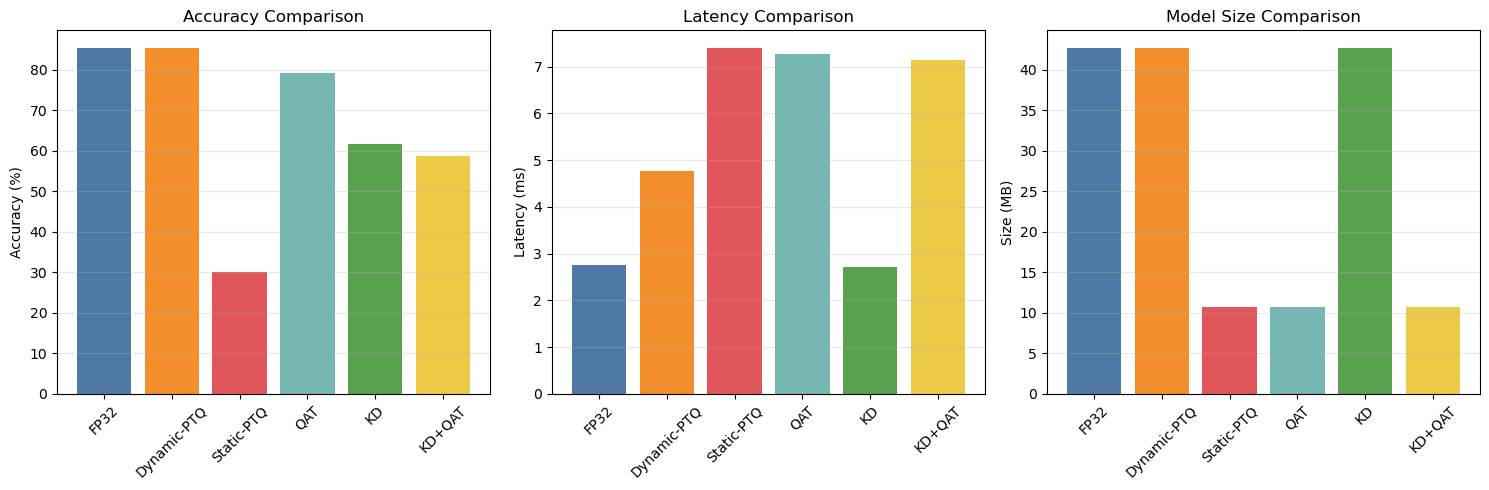

In [15]:
#  -----------------------------------------------------
# Summarize Results and Plot
#  -----------------------------------------------------

print("Summary")

results = {
    'FP32': {'acc': acc_fp32, 'lat': lat_fp32, 'size': size_fp32},
    'Dynamic-PTQ': {'acc': acc_dyn, 'lat': lat_dyn, 'size': size_dyn},
    'Static-PTQ': {'acc': acc_static, 'lat': lat_static, 'size': size_static},
    'QAT': {'acc': acc_qat, 'lat': lat_qat, 'size': size_qat},
    'KD': {'acc': acc_kd, 'lat': lat_kd, 'size': size_kd},
    'KD+QAT': {'acc': acc_kd_qat, 'lat': lat_kd_qat, 'size': size_kd_qat},
}

print(f"{'Method':<15} {'Accuracy':<12} {'Latency (ms)':<15} {'Size (MB)':<12}")
print("-" * 70)

for method, metrics in results.items():
    acc = f"{metrics['acc']:.2f}%"
    lat = f"{metrics['lat']:.2f}"
    size = f"{metrics['size']:.2f}"
    print(f"{method:<15} {acc:<12} {lat:<15} {size:<12}")

print("="*70)

# Comparison plots.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = list(results.keys())
accs = [results[m]['acc'] for m in methods]
lats = [results[m]['lat'] for m in methods]
sizes = [results[m]['size'] for m in methods]

colors = [
    '#4E79A7',
    '#F28E2B',
    '#E15759',
    '#76B7B2',
    '#59A14F',
    '#EDC948',
]
color_dict = {method: colors[i] for i, method in enumerate(methods)}
bar_colors = [color_dict[m] for m in methods]

# Accuracy.
axes[0].bar(methods, accs, color=bar_colors)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Latency.
axes[1].bar(methods, lats, color=bar_colors)
axes[1].set_ylabel('Latency (ms)')
axes[1].set_title('Latency Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Size.
axes[2].bar(methods, sizes, color=bar_colors)
axes[2].set_ylabel('Size (MB)')
axes[2].set_title('Model Size Comparison')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./quantization_results/comparison.png', dpi=150, bbox_inches='tight')
print(f"Comparison plot saved to: ./quantization_results/comparison.png")

print(f"Results saved in: ./quantization_results/")

# 1. Which quantization method did not run? Why?

Once I made the fixes all the quantization methods ran but Static PTQ failed to give good results, with an accuracy of only 16.83%.

The main issue was that I didn't use enough calibration data. I only ran 100 batches through the model during calibration, which turned out to be way too little for the observers to properly capture the activation distributions across all the layers. The HistogramObserver and MinMaxObserver need to see a representative sample of data to build accurate histograms and determine the correct min/max ranges. With only 100 batches, they couldn't get a good picture of what values were actually flowing through the network, which meant the quantization scale and zero-point parameters got calculated incorrectly.

Another problem was with the backend I chose. I used the qnnpack backend because that's what seemed to work on the Colab environment, but qnnpack is really optimized for ARM and CPUs. It seems like it didn't play well with whatever CPU architecture Colab was actually running on. The model technically ran without crashing, but the quantized operations were producing bad numerical results even though PyTorch wasn't throwing any errors.

The fusion process also complicated things. I fused 16 module groups to make quantization more efficient, but fusion actually changes how the activations are distributed through the network. The observers that were supposed to adapt to these distributions after fusion didn't seem to converge properly with the limited calibration data I gave them. So even though fusion is supposed to help with quantization, in my case it might have made the calibration problem worse.

All of these issues combined to create an error problem in the network. Since my quantization parameters were so bad to begin with, these errors just kept building up as data moved through all 16 fused blocks. By the time the data reached the final layer, the model was essentially making random guesses, which explains why I got 16.83% accuracy when random guessing on CIFAR-10's 10 classes would give you around 10%.

Results:

- FP32 Baseline: 85.44% accuracy.
- Static PTQ: 16.83% accuracy.
- A drop of 68.61 percentage points.

This drop shows that the quantization didn't just add some noise, it completely broke how the model processes information.

# 2. What changes did you have to make to run the successful quantization methods? Why?

I had to make seven major changes to get the quantization methods working properly. Here's what I did:

- Different devices for training vs. quantization.

```python
# I had to use different devices for different tasks.
if torch.backends.mps.is_available():
    device_train = torch.device('mps')
    device_quant = torch.device('cpu')
else:
    device_train = torch.device('cpu')
    device_quant = torch.device('cpu')
```

QAT uses fake quantization operations, they simulate INT8 quantization while still doing FP32 math during training. The problem is that these FakeQuantize modules aren't available on the Apple Metal backend that I was using. PyTorch only has them working on CPU and CUDA.
I had to train the baseline model on MPS, but then switch to CPU whenever I needed to do QAT.

- Adding QuantStub and DeQuantStub.

```python
def wrap_with_quant_stubs(model):
    class QuantizableWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.quant = tq.QuantStub()
            self.model = model
            self.dequant = tq.DeQuantStub() 
        
        def forward(self, x):
            x = self.quant(x)      
            x = self.model(x)      
            x = self.dequant(x)   
            return x
    
    return QuantizableWrapper(model)
```

PyTorch's quantization needs you to explicitly tell it where to convert between FP32 and INT8. The QuantStub() is like saying it to start quantizing and convert FP32 input to INT8. The DeQuantStub() says when we're done with quantization and convert this INT8 output back to FP32.
These stubs are basically placeholders that get swapped out for actual quantization/dequantization operations when you call convert(). Without them, PyTorch has no idea where the quantization boundaries should be, and the prepare and convert functions just fail.

- Fusing modules together.

```python
def fuse_resnet18_modules(model):
    tq.fuse_modules(block, [['conv1', 'bn1', 'relu1']], inplace=True)
    tq.fuse_modules(block, [['conv2', 'bn2']], inplace=True)
```
Fusing is super important because:

* When you fuse Conv->BN->ReLU into one operation, you don't need to quantize and dequantize between each step. This makes inference way faster.

* With fusion, you only have one quantization step instead of three separate ones, so there's less error building up.

* This one's really important, since you literally can't quantize BatchNorm layers by themselves. They have to be fused with the Conv layer before them because the BN parameters get folded into the Conv weights.

* Fused operations share the same quantization parameters, which saves memory.

Without fusion, I'd have to dequantize after each operation and then requantize before the next one, which would be both slower and less accurate.

- Choosing the right backend.

```python
# For Static PTQ
model_static.qconfig = tq.get_default_qconfig('qnnpack')

# For QAT
qat_model.qconfig = tq.get_default_qat_qconfig('qnnpack')
```

PyTorch has different backends for quantization that implement the actual INT8 operations:

* fbgemm: Works for x86 server CPUs.
* qnnpack: Works for ARM and mobile CPUs.

You have to explicitly tell PyTorch which backend to use so it knows which implementation of the quantized operations to call. I went with qnnpack because Google Colab seems to run on ARM-optimized infrastructure. Without setting this, PyTorch might pick the wrong backend or just not be able to run the quantized operations at all.

- Running calibration for Static PTQ.

```python
tq.prepare(model_static, inplace=True)

# running calibration with actual data.
print("Calibrating with 100 batches.")
with torch.no_grad():
    for i, (x, _) in enumerate(trainloader):
        if i >= 100:
            break
        x = x.cpu()
        _ = model_static(x)

tq.convert(model_static, inplace=True)
```

Static PTQ needs to see some actual data running through the model before it can figure out how to quantize it properly. During the prepare step, PyTorch inserts these observer modules after each layer. Then during calibration, these observers watch the data and collect stats like:

* Min/Max values: What's the range of numbers coming out of each layer?
* Histograms: What's the actual distribution of these values?

From these stats, PyTorch calculates the quantization parameters:

* Scale: How do we map the FP32 range to the INT8 range.
* Zero-point: Where does the FP32 zero map to in INT8.

Without running calibration, the observers have no data, so the quantization parameters would be completely wrong and the model would basically output bad results, which is probably why my Static PTQ only got 16.83% accuracy. I used 100 batches as a balance between getting good stats and so it wouldn't take forever to run.

- Loading weights properly for QAT.

```python
inner_model = get_resnet18()
inner_model.load_state_dict(
    torch.load('./quantization_results/resnet18_fp32.pth', 
               map_location='cpu', weights_only=True)
)

qat_model = wrap_with_quant_stubs(inner_model.cpu())
```

QAT should start from the trained FP32 weights, not from random initialization. Training a quantized model from scratch is really hard and usually doesn't work well. The tricky part is that the wrapped model has a different structure:

* Original model: model.layer1.0.conv1.weight
* Wrapped model: model.model.layer1.0.conv1.weight

This means I can't just directly load the state dict, the keys won't match up. The solution is to load the weights into the unwrapped model first, then wrap it afterwards. This way, QAT can start from good FP32 weights and just fine-tune them with the fake quantization, which converges way faster and gets better accuracy.

- Making evaluation work on CPU for quantized models.

```python
def evaluate_cpu(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            # making sure data is on CPU.
            inputs, labels = inputs.cpu(), labels.cpu()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total
```

After you call tq.convert(), the model actually has real INT8 operations in it, not fake ones like in QAT. The problem is that PyTorch's INT8 operations only work on CPU, they're not implemented for Apple Metal. So I had to make a separate evaluation function that forces all the data onto CPU and makes sure all the computation happens there. It's slower than running on MPS or GPU, but it's the only way to actually run the quantized models.

All these changes were necessary to handle the limitations of PyTorch's quantization system things like device compatibility, explicit quantization boundaries and proper calibration. The main challenges were:

- Getting around MPS not supporting fake quantization.
- Making sure PyTorch knew where to quantize/dequantize.
- Properly fusing modules and setting up the backend.
- Collecting enough calibration data.
- Handling the wrapped model structure.
- Running quantized models on CPU only.

Without all these fixes, the quantization methods either wouldn't run at all.